In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime #Monday's weekday is 0
from matplotlib import pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from sklearn import tree
#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

#import datasets
train = pd.read_csv('../input/train_subsampled.csv')
#train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [2]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


1. **Feature Engineering**

In [3]:
 # Creating three new features: weekday, hour and trip duration and add them to an engineered dataset.
 # Do this inside a function so we don't have to repeat it to the test set
def append_features(dataset):
    dataset_eng = dataset.copy()
    dataset_eng['pickup_datetime'] = dataset_eng.pickup_datetime.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    dataset_eng['pickup_weekday'] = dataset_eng.pickup_datetime.apply(datetime.weekday)
    dataset_eng['pickup_hour'] = dataset_eng.pickup_datetime.apply(lambda x: x.hour)
    dataset_eng['distance'] = np.sqrt( 
                                    (dataset.dropoff_latitude - dataset.pickup_latitude).pow(2) + 
                                    (dataset.dropoff_longitude - dataset.pickup_longitude).pow(2) )
    #the following features only apply for the training set
    if 'dropoff_datetime' in dataset.columns:
        dataset_eng['dropoff_datetime'] = dataset_eng.dropoff_datetime.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        dataset_eng['duration'] = dataset_eng['dropoff_datetime'] - dataset_eng['pickup_datetime'] 
        dataset_eng['duration_in_seconds'] = dataset_eng['duration'].apply(lambda x : x.seconds)
    return dataset_eng

In [4]:
train_eng = append_features(train)
train_eng.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_weekday,pickup_hour,distance,duration,duration_in_seconds
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.050375e+00,1.360648e+01,3.548232e-02,0 days 00:15:59.492272,9.529766e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,1.954039e+00,6.399693e+00,4.596807e-02,0 days 01:27:17.431724,3.172881e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0 days 00:00:01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,1.000000e+00,9.000000e+00,1.258443e-02,0 days 00:06:37,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,3.000000e+00,1.400000e+01,2.121671e-02,0 days 00:11:02,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.000000e+00,1.900000e+01,3.840884e-02,0 days 00:17:55,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,6.000000e+00,2.300000e+01,1.119260e+01,40 days 19:31:22,8.639200e+04


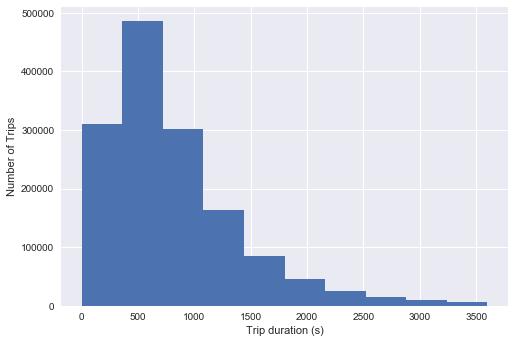

In [5]:
fig1 = train_eng[train_eng['duration_in_seconds']<3600*1].duration_in_seconds.hist()
fig1.set_xlabel("Trip duration (s)")
fig1.set_ylabel("Number of Trips")
plt.show()

In [6]:
## Function that receives a column of values already grouped by weekday and hour and aggregated, and plots the heat map
def plot_per_weekday_hour(aggregated_data, title = ''):
    fig = sns.heatmap(aggregated_data.values.reshape((7,24)), cmap = 'jet')
    fig.set_xlabel('Hour')
    fig.set_ylabel('Day of the week')
    fig.set_title(title)
    plt.show()


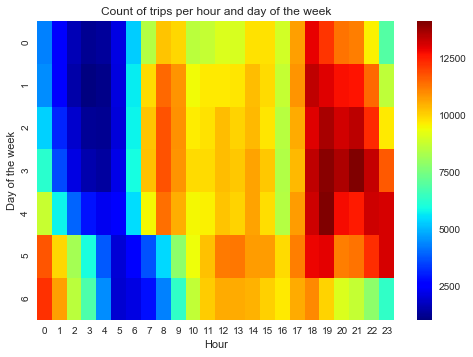

In [7]:
#keep only trips that took less than 1 hour
aggregated_set = train_eng[train_eng['duration_in_seconds']<3600*1].groupby(['pickup_weekday','pickup_hour'])

plot_per_weekday_hour(aggregated_set.count()['id'], 
                      'Count of trips per hour and day of the week')

Most busy hours are between 17-24h on every day of the week except for Sundays

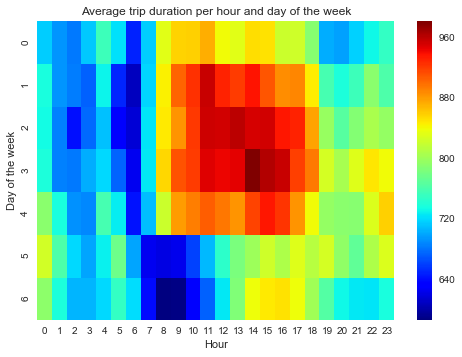

In [8]:
plot_per_weekday_hour(aggregated_set.mean()['duration_in_seconds'], 
                      'Average trip duration per hour and day of the week')

Longest trips happen from Tuesday to Friday between 10 and 17h (perhaps due to traffic?)

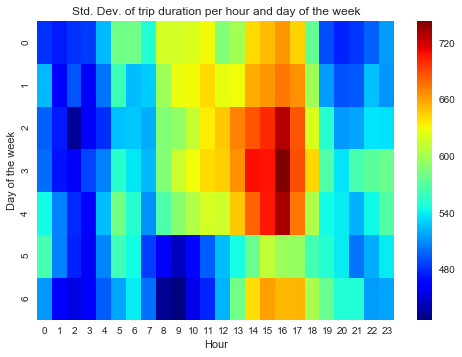

In [9]:
plot_per_weekday_hour(aggregated_set.std()['duration_in_seconds'], 
                      'Std. Dev. of trip duration per hour and day of the week')

### Clustering by dropoff and pickup positions, hour and day of the week

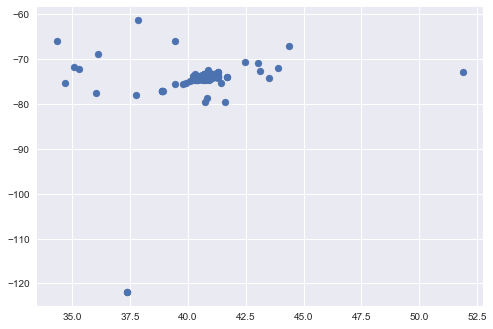

In [10]:
plt.scatter(train.pickup_latitude, train.pickup_longitude)
plt.show()

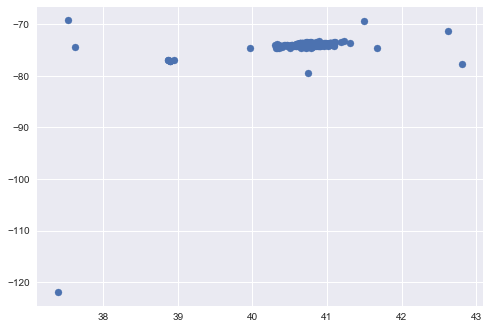

In [11]:
plt.scatter(test.pickup_latitude, test.pickup_longitude)
plt.show()

Some trips are way more distant and take longer than the rest so it won't be possible to obtain an accurate estimate from their neighbors, i.e clustering won't work for these ones...

Perhaps linear regression could be more useful in these cases!

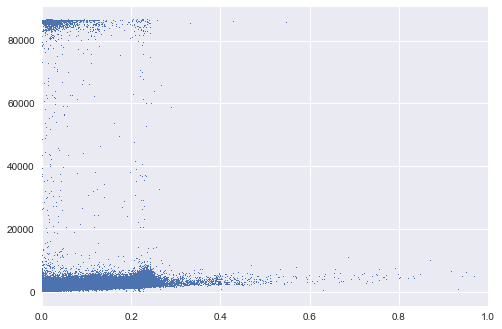

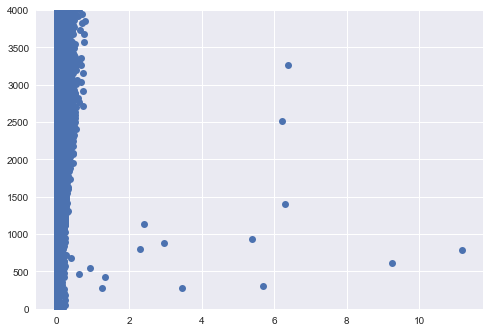

In [12]:
ax = plt.plot(train_eng.distance, train_eng.duration_in_seconds,',')
plt.xlim(0,1)
plt.show()

ax = plt.plot(train_eng.distance, train_eng.duration_in_seconds,'o')
plt.ylim(0,4000)
plt.show()

In [10]:
test_eng = append_features(test)
test_eng.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_weekday,pickup_hour
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816,3.047670,13.610228
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824,1.953951,6.394761
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322,0.000000,0.000000
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000,1.000000,9.000000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543,3.000000,14.000000
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852,5.000000,19.000000
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597,6.000000,23.000000


2. Classifier
    Train

In [11]:
X = train_eng[['pickup_hour','pickup_weekday']]
Y = train_eng.duration_in_seconds

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X,Y)

    Predict

In [12]:
pred = clf.predict(test_eng[['pickup_hour','pickup_weekday']])

In [13]:
pred

array([ 921.92129748,  921.92129748,  921.92129748, ...,  930.79177583,
        930.79177583,  930.79177583])